# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import os
import sys
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from functools import partial
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Wed Jun  1 22:28:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.73       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
|  0%   60C    P0   117W / 350W |   1312MiB / 12288MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

# Navier-Stokes equation
$$
\begin{cases}
  \displaystyle
  \partial_t u_i(t,x) + \nu \Delta u_i(t,x)
  =
  \partial_{1_i} p(t,x)
 + \sum\limits_{j=0}^{d-1} u_j(t,x) \partial_{1_j} u_i(t,x),
 \quad
 i = 0,\ldots , d-1,
  \\
u_i(T,x) = \phi_i (x),
  \\
  \displaystyle
  \Delta u_{-1}(t, x)
  = -\sum\limits_{i,j=0}^{d-1}
\partial_{1_j} u_i(t,x)
\partial_{1_i} u_j(t,x),
   \\
\sum\limits_{i = 0}^{d - 1}
\partial_{1_i} u_i(t, x) = 0,
\quad (t,x) = (t,x_1, \ldots, x_d) \in [0,T] \times \mathbb{R}^d.
\end{cases}
$$

## 2-dimensional Taylor-Green vortex
$$
\begin{cases}
  \displaystyle
  u_1(t, x) = - \cos(x_1) \sin(x_2) e^{-2\nu (T - t)},
  \\
  u_2(t, x) = \sin(x_1) \cos(x_2) e^{-2\nu (T - t)},
  \\
  \displaystyle
  u_0(t, x) = -\frac{1}{4} \left(\cos(2x_1) + \cos(2x_2)\right) e^{-4\nu (T - t)} + c
\end{cases}
$$
$x=(x_1,x_2) \in [0,2\pi]^2$,


In [4]:
# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return -torch.cos(x[0]) * torch.sin(x[1])
    else:
        return torch.sin(x[0]) * torch.cos(x[1])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return -np.cos(x[0]) * np.sin(x[1]) * np.exp(-nu * (T - t))
    else:
        return np.sin(x[0]) * np.cos(x[1]) * np.exp(-nu * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return -torch.cos(tx[1]) * torch.sin(tx[2]) * torch.exp(-nu * (T - tx[0]))
    else:
        return torch.sin(tx[1]) * torch.cos(tx[2]) * torch.exp(-nu * (T - tx[0]))

def exact_example_p_tensor(tx):
    return (
        -1/ 4
        * torch.exp(-2 * nu * (T - tx[0]))
        * (torch.cos(2 * tx[1]) + torch.cos(2 * tx[2]))
    )

problem_name = "taylor_green_2d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .25, nu = 2

Logs are saved in /home/nguwijy/tmp/deep_branching_with_domain/logs/20220601-222808-taylor_green_2d-T0.25-nu2
Patch 0: generation of p samples take 463.4726519584656 seconds.
Patch  0: epoch    0 with loss 2.97E+00
Patch  0: epoch  500 with loss 3.04E-03
Patch  0: epoch 1000 with loss 2.13E-03
Patch  0: epoch 1500 with loss 5.29E-04
Patch  0: epoch 2000 with loss 4.36E-04
Patch  0: epoch 2500 with loss 4.32E-04
Patch  0: epoch 3000 with loss 4.20E-04
Patch  0: epoch 3500 with loss 4.04E-04
Patch  0: epoch 4000 with loss 3.86E-04
Patch  0: epoch 4500 with loss 3.64E-04
Patch  0: epoch 5000 with loss 3.40E-04
Patch  0: epoch 5500 with loss 3.13E-04
Patch  0: epoch 6000 with loss 2.84E-04
Patch  0: epoch 6500 with loss 2.53E-04
Patch  0: epoch 7000 with loss 2.22E-04
Patch  0: epoch 7500 with loss 1.93E-04
Patch  0: epoch 8000 with loss 1.63E-04
Patch  0: epoch 8500 with loss 1.39E-04
Patch  0: epoch 9000 with loss 1.17E-04
Patch  0: epoch 9500 with loss 9.93E-05
Patch  0: epoch 9999 with

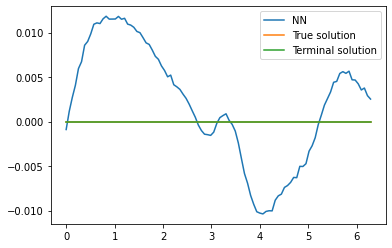

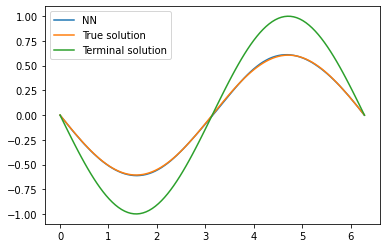

In [5]:
T, nu = .25, 2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

taylor_green_reuse_checkpoint = model.working_dir

### T = 1, nu = .2

Logs are saved in /home/nguwijy/tmp/deep_branching_with_domain/logs/20220601-230945-taylor_green_2d-T1-nu0.2
Patch 0: generation of u samples take 1006.3316013813019 seconds.
Patch  0: epoch    0 with loss 7.23E-02
Patch  0: epoch  500 with loss 3.80E-04
Patch  0: epoch 1000 with loss 1.09E-04
Patch  0: epoch 1500 with loss 7.67E-05
Patch  0: epoch 2000 with loss 6.96E-05
Patch  0: epoch 2500 with loss 6.90E-05
Patch  0: epoch 3000 with loss 6.80E-05
Patch  0: epoch 3500 with loss 6.69E-05
Patch  0: epoch 4000 with loss 6.55E-05
Patch  0: epoch 4500 with loss 6.39E-05
Patch  0: epoch 5000 with loss 6.20E-05
Patch  0: epoch 5500 with loss 5.99E-05
Patch  0: epoch 6000 with loss 5.76E-05
Patch  0: epoch 6500 with loss 5.51E-05
Patch  0: epoch 7000 with loss 5.24E-05
Patch  0: epoch 7500 with loss 4.96E-05
Patch  0: epoch 8000 with loss 4.67E-05
Patch  0: epoch 8500 with loss 4.38E-05
Patch  0: epoch 9000 with loss 4.09E-05
Patch  0: epoch 9500 with loss 3.83E-05
Patch  0: epoch 9999 with

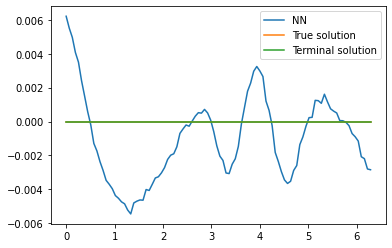

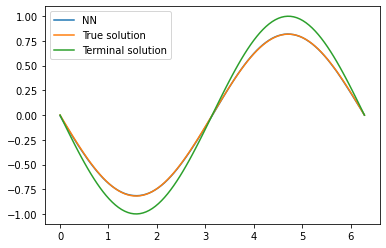

In [6]:
T, nu = 1, .2

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

### T = 10, nu = .02

Logs are saved in /home/nguwijy/tmp/deep_branching_with_domain/logs/20220601-233151-taylor_green_2d-T10-nu0.02
Patch 0: generation of u samples take 976.4478607177734 seconds.
Patch  0: epoch    0 with loss 2.58E-01
Patch  0: epoch  500 with loss 6.60E-03
Patch  0: epoch 1000 with loss 1.31E-04
Patch  0: epoch 1500 with loss 1.06E-04
Patch  0: epoch 2000 with loss 9.02E-05
Patch  0: epoch 2500 with loss 9.02E-05
Patch  0: epoch 3000 with loss 8.83E-05
Patch  0: epoch 3500 with loss 8.60E-05
Patch  0: epoch 4000 with loss 8.32E-05
Patch  0: epoch 4500 with loss 7.99E-05
Patch  0: epoch 5000 with loss 7.61E-05
Patch  0: epoch 5500 with loss 7.20E-05
Patch  0: epoch 6000 with loss 6.72E-05
Patch  0: epoch 6500 with loss 6.31E-05
Patch  0: epoch 7000 with loss 5.87E-05
Patch  0: epoch 7500 with loss 5.42E-05
Patch  0: epoch 8000 with loss 4.98E-05
Patch  0: epoch 8500 with loss 4.48E-05
Patch  0: epoch 9000 with loss 4.13E-05
Patch  0: epoch 9500 with loss 3.82E-05
Patch  0: epoch 9999 wit

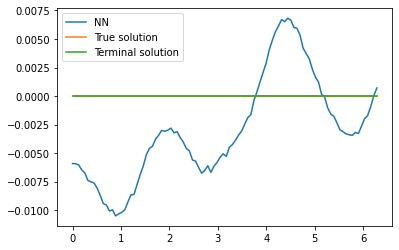

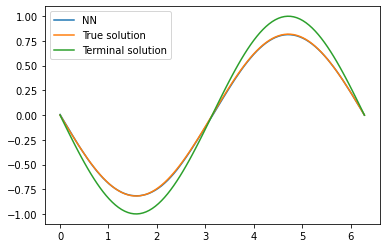

In [7]:
T, nu = 10, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=taylor_green_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*126+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

## 3-dimensional ABC flow

In [8]:
A = B = C = 0.5

# function definition
deriv_map = np.array(
    [
        [1, 0, 0],  # for nabla p
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0],  # for u
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],  # for nabla u1
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u2
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],  # for nabla u3
        [0, 1, 0],
        [0, 0, 1],
    ]
)
zeta_map = np.array([-1, -1, -1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
deriv_condition_deriv_map = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1, 2])

_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return A * torch.sin(x[2]) + C * torch.cos(x[1])
    elif coordinate == 1:
        return B * torch.sin(x[0]) + A * torch.cos(x[2])
    else:
        return C * torch.sin(x[1]) + B * torch.cos(x[0])

def exact_example(t, x, T, coordinate, nu):
    if coordinate == 0:
        return (A * np.sin(x[2]) + C * np.cos(x[1])) * np.exp(-nu / 2 * (T - t))
    elif coordinate == 1:
        return (B * np.sin(x[0]) + A * np.cos(x[2])) * np.exp(-nu / 2 * (T - t))
    else:
        return (C * np.sin(x[1]) + B * np.cos(x[0])) * np.exp(-nu / 2 * (T - t))

def exact_example_u_tensor(tx, coordinate, T, nu):
    if coordinate == 0:
        return (A * torch.sin(tx[3]) + C * torch.cos(tx[2])) * torch.exp(-nu / 2 * (T - tx[0]))
    elif coordinate == 1:
        return (B * torch.sin(tx[1]) + A * torch.cos(tx[3])) * torch.exp(-nu / 2 * (T - tx[0]))
    else:
        return (C * torch.sin(tx[2]) + B * torch.cos(tx[1])) * torch.exp(-nu / 2 * (T - tx[0]))

def exact_example_p_tensor(tx):
    return -torch.exp(-nu * (T - tx[0])) * (
        A * C * torch.sin(tx[3]) * torch.cos(tx[2])
        + B * A * torch.sin(tx[1]) * torch.cos(tx[3])
        + C * B * torch.sin(tx[2]) * torch.cos(tx[1])
    )

problem_name = "abc_3d"
t_lo, x_lo, x_hi = 0., 0, 2 * math.pi

### T = .7, nu = .02

Logs are saved in /home/nguwijy/tmp/deep_branching_with_domain/logs/20220601-235327-abc_3d-T0.7-nu0.02
Patch 0: generation of p samples take 1001.6222875118256 seconds.
Patch  0: epoch    0 with loss 9.92E-01
Patch  0: epoch  500 with loss 1.10E-02
Patch  0: epoch 1000 with loss 3.28E-02
Patch  0: epoch 1500 with loss 2.53E-03
Patch  0: epoch 2000 with loss 2.07E-03
Patch  0: epoch 2500 with loss 2.10E-03
Patch  0: epoch 3000 with loss 2.05E-03
Patch  0: epoch 3500 with loss 1.97E-03
Patch  0: epoch 4000 with loss 1.88E-03
Patch  0: epoch 4500 with loss 1.76E-03
Patch  0: epoch 5000 with loss 1.61E-03
Patch  0: epoch 5500 with loss 1.47E-03
Patch  0: epoch 6000 with loss 1.32E-03
Patch  0: epoch 6500 with loss 1.16E-03
Patch  0: epoch 7000 with loss 1.00E-03
Patch  0: epoch 7500 with loss 8.54E-04
Patch  0: epoch 8000 with loss 7.24E-04
Patch  0: epoch 8500 with loss 6.19E-04
Patch  0: epoch 9000 with loss 5.31E-04
Patch  0: epoch 9500 with loss 4.71E-04
Patch  0: epoch 9999 with loss 

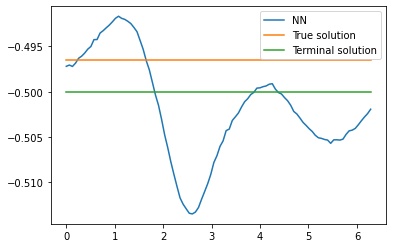

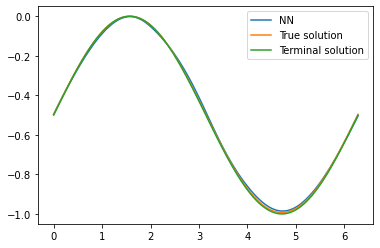

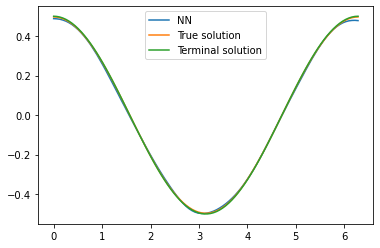

In [9]:
T, nu = .7, .02

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))

abc_reuse_checkpoint = model.working_dir

### T = .7, nu = .0002

Logs are saved in /home/nguwijy/tmp/deep_branching_with_domain/logs/20220602-013139-abc_3d-T0.7-nu0.0002
Patch 0: generation of u samples take 3358.876378297806 seconds.
Patch  0: epoch    0 with loss 8.74E-05
Patch  0: epoch  500 with loss 2.07E-04
Patch  0: epoch 1000 with loss 1.05E-04
Patch  0: epoch 1500 with loss 7.74E-05
Patch  0: epoch 2000 with loss 6.97E-05
Patch  0: epoch 2500 with loss 6.88E-05
Patch  0: epoch 3000 with loss 6.77E-05
Patch  0: epoch 3500 with loss 6.62E-05
Patch  0: epoch 4000 with loss 6.45E-05
Patch  0: epoch 4500 with loss 6.23E-05
Patch  0: epoch 5000 with loss 5.97E-05
Patch  0: epoch 5500 with loss 5.67E-05
Patch  0: epoch 6000 with loss 5.33E-05
Patch  0: epoch 6500 with loss 4.95E-05
Patch  0: epoch 7000 with loss 4.54E-05
Patch  0: epoch 7500 with loss 4.11E-05
Patch  0: epoch 8000 with loss 3.69E-05
Patch  0: epoch 8500 with loss 3.28E-05
Patch  0: epoch 9000 with loss 2.89E-05
Patch  0: epoch 9500 with loss 2.56E-05
Patch  0: epoch 9999 with loss

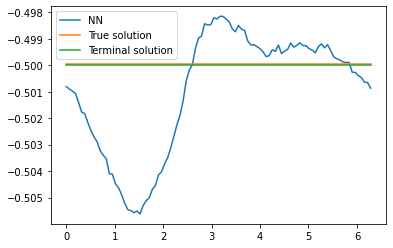

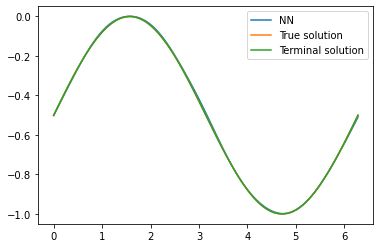

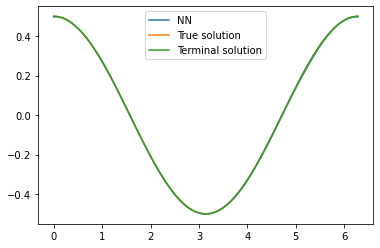

In [10]:
T, nu = .7, .0002

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,
    branch_nb_states_per_batch=1000,
    fix_all_dim_except_first=False,
    epochs=10000,
    lr_gamma=0.1,
    branch_lr=1e-2,
    branch_activation="tanh",
    neurons=100,
    layers=2,
    fix_t_dim=False,
    save_for_best_model=False,
    outlier_multiplier=10,
    continue_from_checkpoint=abc_reuse_checkpoint,
)
model.train_and_eval()
model.error_calculation(
    exact_u_fun=partial(exact_example_u_tensor, nu=nu, T=T),
    exact_p_fun=exact_example_p_tensor,
    nb_pts_spatial=2*45+1
)
model.compare_with_exact(exact_fun=partial(exact_example, nu=nu))